In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

import torch 
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, random_split


from tqdm import tqdm 

import psweep as ps

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path
import utils_data, utils_spikes, utils_events, utils_tensor, utils_pcn 

sys.path.append('../code/models')  # Add the models directory to the Python path
import pcn

# Well I have to admit I didn't think it would work this good
## Now for the final piece : getting spikes from commands 
### We will train the PCN on "expert dishes" (15-20mn), then get the motor spikes that are either "up" or "down" commands, and use the reverse backwards mode to generate spikes for optimal sensory control
### We will also do it on "naive dishes" (0-5mn) to compare how orthogonal the up-down representations are 

# Parameters

In [3]:
# Experiment specific parameters 
chip_ids = [9501, 11614, 11615] # experiment ID
chip_sessions = [0,2] # 2 for post-training, 0 for pre-training

# Stable parameters
data_path = '../data/cortical_labs_data/' # path to data
fs = 20000 # sampling frequency
binsize = 100 # ms, bin size for spike counts
array_size = 1024 # number of electrode in the array

# Torch parameters 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
num_workers = 2
pin_memory = False

# Learn parameters
batch_size = 32
epochs = 70  # should be enough given the 07-07 notebook
n_inferences_steps = 500  # number of inference steps per input
n_generative_steps = 500 # number of generative steps per input

# Layer parameters
update_weights_flag = True  # whether to learn the FF weights
f = utils_pcn.tanh
df = utils_pcn.tanh_deriv

# Network parameters
fixed_predictions = True  # change the predictions or not
theta_lr = 5e-4
mu_lr = 5e-2
weight_clamp = 50  # weight clamp
mu_clamp = 1000  # value neuron clamp

L1_size = 256
L2_size = 128
L3_size = 256

RUNNING THE MODEL WITH SPIKES ON THE TIME WINDOW :  0  -  300  s
Loading for chip 9501, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 41.04it/s]


Stimulation mode: full game


Binning sensory channels: 100%|██████████| 500/500 [00:00<00:00, 12095.35it/s]
/media/hugo/HDD Alpha/github-hdd/BrainDishSiMulator/notebooks/../code/utils/utils_tensor.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(binned_spikes)
Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 11078.46it/s]


------------------------

Loading for chip 9501, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 44.24it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 10581.79it/s]


------------------------

Loading for chip 11614, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 44.47it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 11455.47it/s]


------------------------

Loading for chip 11614, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 44.67it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 10937.48it/s]


------------------------

Loading for chip 11615, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 44.18it/s]


>>Could not load chip 11615, session 0<<
------------------------

Loading for chip 11615, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 45.12it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 13121.14it/s]


------------------------

Layer 0  :  500  ->  256
Layer 1  :  256  ->  128
Layer 2  :  128  ->  256
Layer 3  :  256  ->  400


Training...: 100%|██████████| 150/150 [4:17:33<00:00, 103.02s/it] 


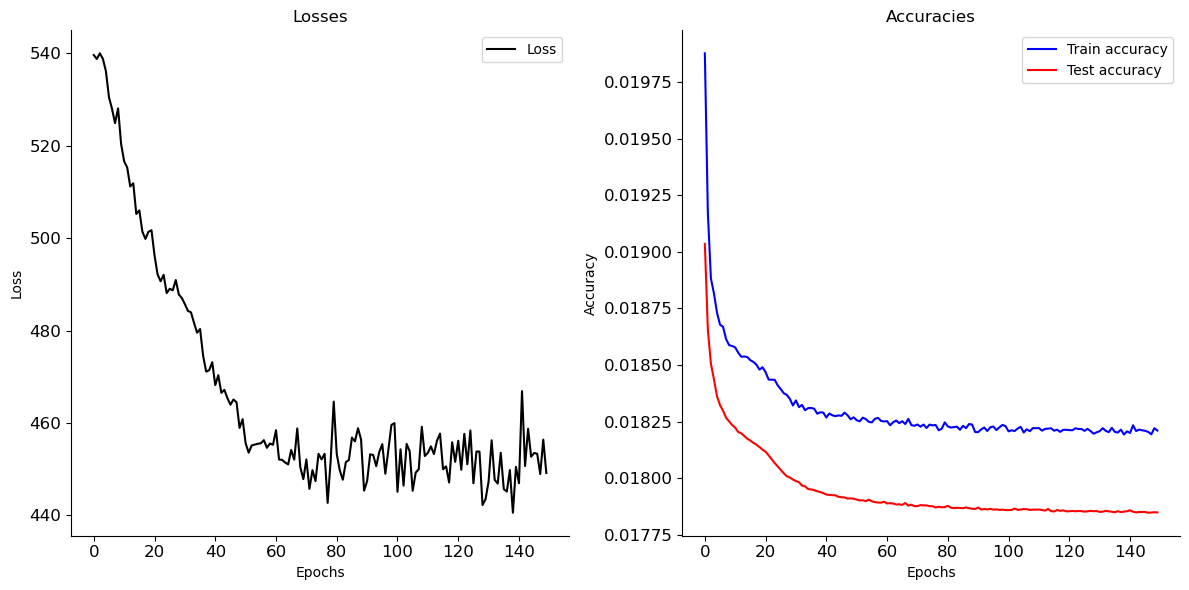

Generating down batches of spikes: 100%|██████████| 50/50 [00:06<00:00,  7.59it/s]
/tmp/ipykernel_639518/877582171.py:130: RuntimeWarning: invalid value encountered in double_scalars
  similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


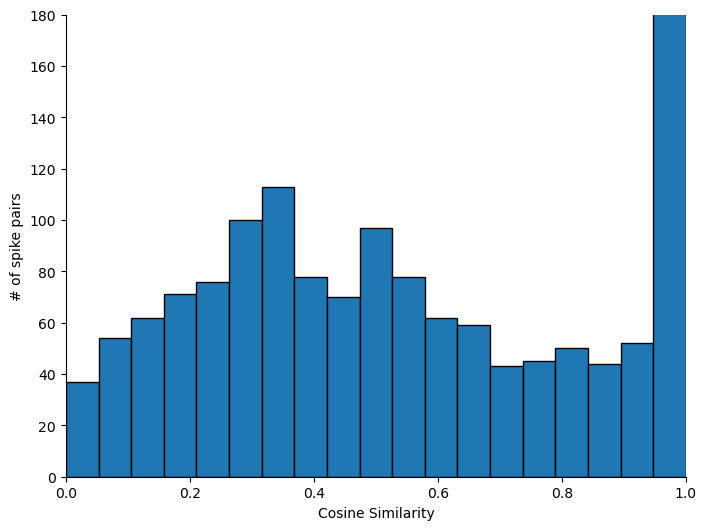

RUNNING THE MODEL WITH SPIKES ON THE TIME WINDOW :  900  -  1200  s
Loading for chip 9501, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 46.38it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 12163.75it/s]


------------------------

Loading for chip 9501, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 47.86it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 10574.32it/s]


------------------------

Loading for chip 11614, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 48.44it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 11704.16it/s]


------------------------

Loading for chip 11614, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 44.39it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 12059.18it/s]


------------------------

Loading for chip 11615, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 47.55it/s]


>>Could not load chip 11615, session 0<<
------------------------

Loading for chip 11615, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 47.20it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 14230.52it/s]


------------------------

Layer 0  :  500  ->  256
Layer 1  :  256  ->  128
Layer 2  :  128  ->  256
Layer 3  :  256  ->  400


Training...: 100%|██████████| 150/150 [4:41:11<00:00, 112.48s/it]  


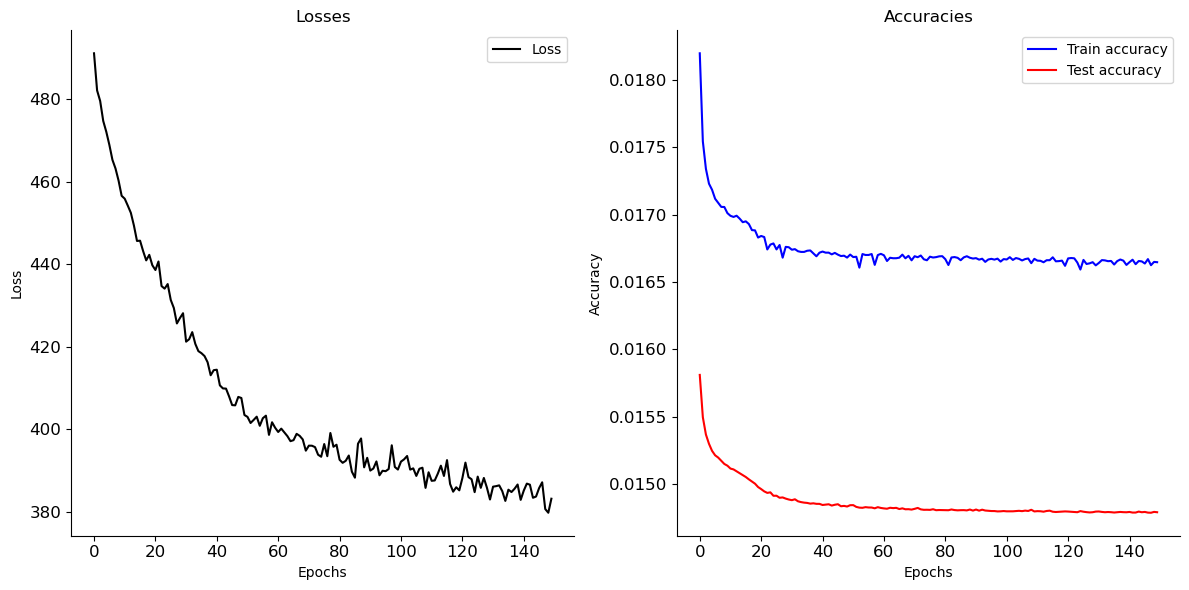

Generating down batches of spikes: 100%|██████████| 50/50 [00:06<00:00,  7.61it/s]
/tmp/ipykernel_639518/877582171.py:130: RuntimeWarning: invalid value encountered in double_scalars
  similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


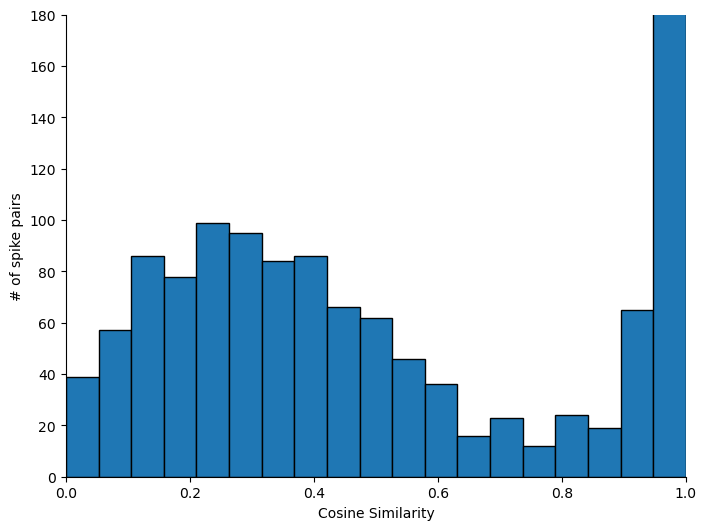

In [4]:
start_time_windows = [60*0, 60*15]
end_time_windows = [60*5, 60*20]

all_up_batches, all_down_batches, all_models = [], [], []
all_losses, all_accs, all_train_accs = [], [], []
for itime_window in range(len(start_time_windows)):
    print('RUNNING THE MODEL WITH SPIKES ON THE TIME WINDOW : ', start_time_windows[itime_window], ' - ', end_time_windows[itime_window], ' s')
    
    
    # -- Getting the data -- #
    start_time_window = start_time_windows[itime_window]
    end_time_window = end_time_windows[itime_window]
    # PEP-8 is crying seeing the line below
    sensory_spikes_binned, motor_spikes_binned, up_spikes_binned, down_spikes_binned = utils_data.get_all_spikes_time_window(start_time_window, end_time_window,
                                                                                                                        binsize, chip_ids, chip_sessions,
                                                                                                                        data_path, array_size, fs)
    
    # -- Getting the up-down labels -- #
    total_up_spikes = up_spikes_binned.sum(dim=0)
    total_down_spikes = down_spikes_binned.sum(dim=0)

    up_timesteps = total_up_spikes > total_down_spikes
    down_timesteps = total_down_spikes > total_up_spikes

    labels = torch.empty(motor_spikes_binned.shape[1], dtype=torch.long)
    labels[up_timesteps] = 1
    labels[down_timesteps] = 0
    
    
    # -- Make the dataset -- #
    # Initialize the dataset for sensory spikes
    dataset_sensory = utils_tensor.NormalizeDataset(sensory_spikes_binned)

    train_size_sensory = int(0.8 * len(dataset_sensory))
    test_size_sensory = len(dataset_sensory) - train_size_sensory
    train_dataset_sensory, test_dataset_sensory = random_split(dataset_sensory, [train_size_sensory, test_size_sensory])

    train_dataloader_sensory = DataLoader(train_dataset_sensory, batch_size=batch_size, shuffle=True,
                                        num_workers = num_workers, pin_memory = pin_memory, drop_last = True)
    test_dataloader_sensory = DataLoader(test_dataset_sensory, batch_size=batch_size, shuffle=False,
                                        num_workers = num_workers, pin_memory = pin_memory, drop_last = True)

    # Initialize the dataset for motor spikes
    dataset_motor = utils_tensor.NormalizeDataset(motor_spikes_binned)

    train_size_motor = int(0.8 * len(dataset_motor))
    test_size_motor = len(dataset_motor) - train_size_motor
    train_dataset_motor, test_dataset_motor = random_split(dataset_motor, [train_size_motor, test_size_motor])

    train_dataloader_motor = DataLoader(train_dataset_motor, batch_size=batch_size, shuffle=True,
                                        num_workers = num_workers, pin_memory = pin_memory, drop_last = True)
    test_dataloader_motor = DataLoader(test_dataset_motor, batch_size=batch_size, shuffle=False,
                                        num_workers = num_workers, pin_memory = pin_memory, drop_last = True)
    
    
    # -- Make the model -- #
    shapes = [sensory_spikes_binned.shape[0], L1_size, L2_size, L3_size, motor_spikes_binned.shape[0]]
    layers = []
    for i in range(len(shapes)-1) :
        print('Layer', i, ' : ', shapes[i], ' -> ', shapes[i+1])
        layers.append(pcn.FCLayer(input_size = shapes[i],
                                output_size = shapes[i+1], f = f, df = df,
                                device = device))
        
    model = pcn.PCNet_Bogacz(layers = layers, batch_size = batch_size,
                    n_inferences_steps = n_inferences_steps,
                    mu_lr = mu_lr, theta_lr = theta_lr, pi_lr = 42,
                    fixed_predictions = fixed_predictions, update_weights_flag=update_weights_flag,
                    weight_clamp = weight_clamp, mu_clamp = mu_clamp,  pi_clamp = 42,
                    device = device, do_pi = False,
                    mode = 'mse')
    
    # GPU burning
    losses, accs, test_accs = pcn.train_mse(model = model,
                                            inputs_dataloader = train_dataloader_sensory, 
                                            outputs_dataloader = train_dataloader_motor,
                                            test_inputs_dataloader = test_dataloader_sensory,
                                            test_outputs_dataloader = test_dataloader_motor, 
                                            n_epochs = epochs)

    utils_pcn.plot_loss_accs(losses, accs, test_accs)
    
    
    # -- Run in generative model -- # 
    n_batches = 50 # we select 50 batches of either up or down spikes pattern for generation 
    up_indices = torch.where(labels == 1)[0]
    down_indices = torch.where(labels == 0)[0]

    up_batches, down_batches  = [], []
    for _ in tqdm(range(n_batches), desc='Generating up batches of spikes'):
        # Randomly permute the indices.
        permuted_up_indices = up_indices[torch.randperm(up_indices.size()[0])]
        selected_indices = permuted_up_indices[:batch_size]

        # Create a mask for the selected indices
        mask = torch.ones(up_indices.size()[0], dtype=bool)
        for index in selected_indices:
            mask[torch.where(up_indices == index)] = False
        up_indices = up_indices[mask]

        # Select the corresponding "up" spike patterns.
        selected_up_spikes = motor_spikes_binned[:, selected_indices].T.to(device)
        gen_firing_rates = model.hard_generate(y=selected_up_spikes, 
                                                n_generative_steps=n_generative_steps)
        up_batches.append(gen_firing_rates)
        
    # Now the same for the "down" spike patterns.
    for _ in tqdm(range(n_batches), desc='Generating down batches of spikes'):
        # Randomly permute the indices.
        permuted_down_indices = down_indices[torch.randperm(down_indices.size()[0])]
        selected_indices = permuted_down_indices[:batch_size]

        # Create a mask for the selected indices
        mask = torch.ones(down_indices.size()[0], dtype=bool)
        for index in selected_indices:
            mask[torch.where(down_indices == index)] = False
        down_indices = down_indices[mask]

        # Select the corresponding "up" spike patterns.
        selected_down_spikes = motor_spikes_binned[:, selected_indices].T.to(device)
        gen_firing_rates = model.hard_generate(y=selected_down_spikes, 
                                                n_generative_steps=n_generative_steps)
        down_batches.append(gen_firing_rates)
        
    up_batches = torch.stack(up_batches).cpu().numpy().reshape(-1, 500)
    down_batches = torch.stack(down_batches).cpu().numpy().reshape(-1, 500)

    similarities = []
    for vec1, vec2 in zip(up_batches, down_batches):
        similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        similarities.append(similarity)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(similarities, edgecolor='k', bins=np.linspace(0, 1, 20))
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('# of spike pairs')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 180])
    ax.spines[['top', 'right']].set_visible(False)
    fig.savefig('../figs/orthogonality_pcn_{}.pdf'.format(itime_window), dpi=300, bbox_inches='tight')
    plt.show()
    
    all_up_batches.append(up_batches)
    all_down_batches.append(down_batches)
    all_models.append(model)
    all_losses.append(losses)
    all_train_accs.append(accs)
    all_accs.append(test_accs)

/tmp/ipykernel_639518/3082673389.py:9: RuntimeWarning: invalid value encountered in double_scalars
  similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


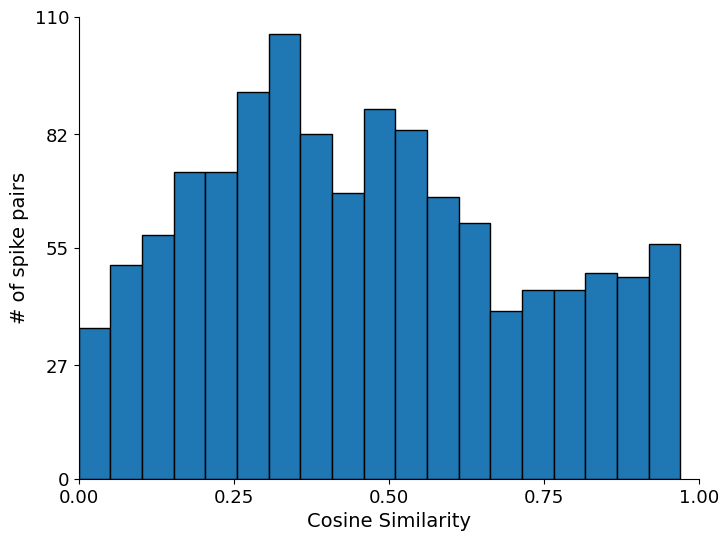

/tmp/ipykernel_639518/3082673389.py:9: RuntimeWarning: invalid value encountered in double_scalars
  similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


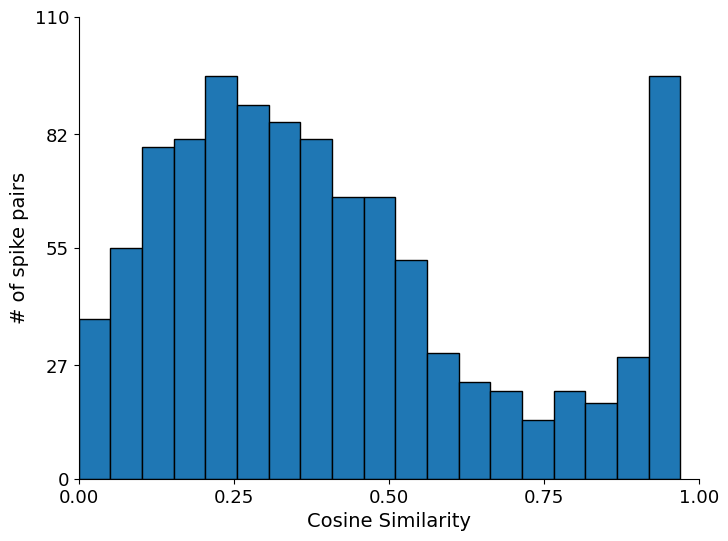

In [73]:
for imodel in range(2):
    up_batches = all_up_batches[imodel]
    down_batches = all_down_batches[imodel]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    similarities = []
    for vec1, vec2 in zip(up_batches, down_batches):
        similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        similarities.append(similarity)
    # remove the nans in similarities
    similarities = [x for x in similarities if str(x) != 'nan']

    ax.hist(similarities, edgecolor='k', bins=np.linspace(0, .97, 20))
    ax.set_xlabel('Cosine Similarity', fontsize = 14)
    ax.set_ylabel('# of spike pairs', fontsize = 14)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 110])
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_yticks(np.linspace(0, 110, 5, dtype=int))
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.tick_params(axis='both', which='major', labelsize=13)
    
    fig.savefig('../figs/orthogonality_pcn_{}.pdf'.format(imodel), dpi=300, bbox_inches='tight')
    plt.show()

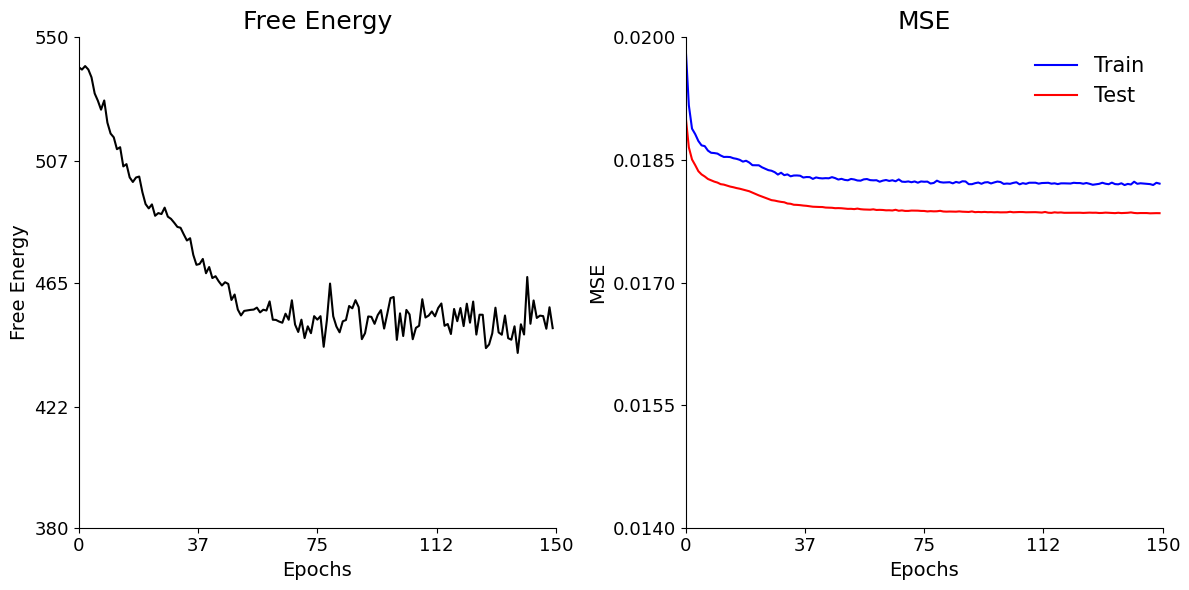

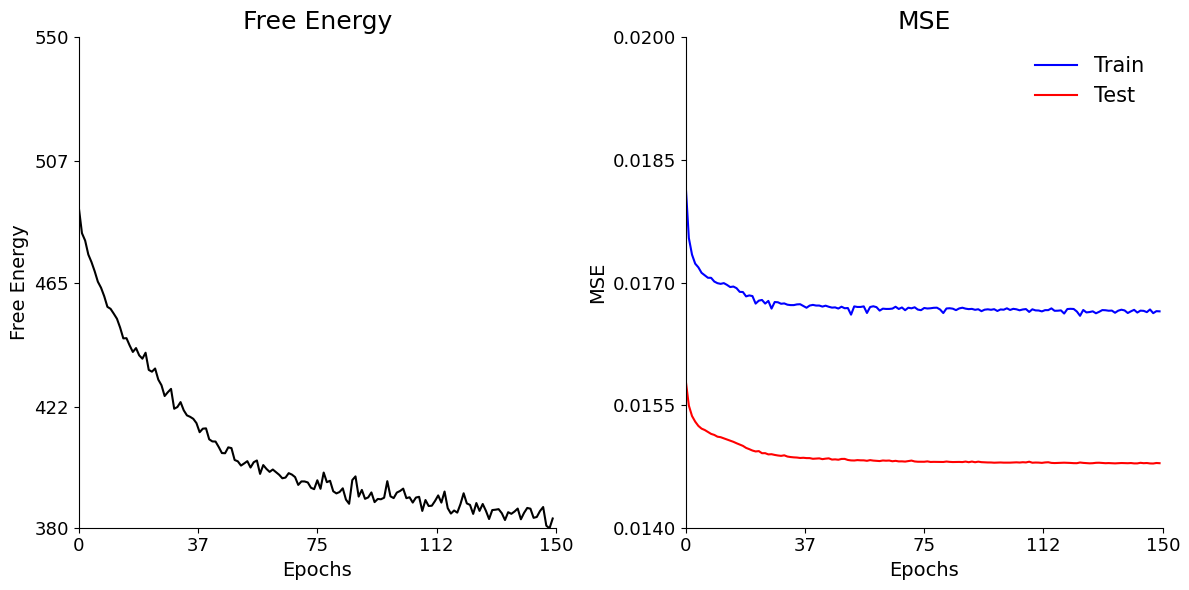

In [72]:
for imodel in range(2):
    fig, axs = plt.subplots(figsize=(12, 6), ncols = 2)
    
    axs[0].plot(all_losses[imodel], c = 'k')
    axs[0].set_title('Free Energy', fontsize = 18)
    axs[0].set_xlabel('Epochs', fontsize = 14)
    axs[0].set_ylabel('Free Energy', fontsize = 14)
    axs[0].set_ylim([380, 550])
    axs[0].set_xlim([0, epochs])
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    axs[0].set_yticks(np.linspace(380, 550, 5, dtype = int))
    
    axs[1].plot(all_train_accs[imodel], c = 'b', label = 'Train')
    axs[1].plot(all_accs[imodel], c = 'r', label = 'Test')
    axs[1].set_title('MSE', fontsize = 18)
    axs[1].set_xlabel('Epochs', fontsize = 14)
    axs[1].set_ylabel('MSE', fontsize = 14)
    axs[1].set_xlim([0, epochs])
    axs[1].set_ylim([0.014, 0.02])
    axs[1].legend(fontsize = 15, loc = 'upper right', frameon = False)
    axs[1].set_yticks(np.round(np.linspace(0.014, 0.02, 5),4))
    
    for ax in axs.flatten() :
        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.spines[['top', 'right']].set_visible(False)
        ax.set_xticks(np.linspace(0, 150, 5), dtype = int)
        ax.set_xticklabels(np.linspace(0, 150, 5, dtype = int))
    
    fig.tight_layout()
    fig.savefig('../figs/learning_curves_{}.pdf'.format(imodel), dpi=300, bbox_inches='tight')